<a href="https://colab.research.google.com/github/ksasi/EVA/blob/master/Project20/Assignment20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning for CIFAR10 Using ImageNet Weights

In [1]:
# Obtain GPU details

!nvidia-smi

Thu Nov 28 08:42:47 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# Install Tensorflow 2.0 GPU version

!pip install tensorflow-gpu

     |████████████████████████████████| 380.8MB 43kB/s 
     |████████████████████████████████| 3.8MB 37.6MB/s 
     |████████████████████████████████| 450kB 64.4MB/s 
     |████████████████████████████████| 81kB 11.1MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found exist

In [3]:
# Import all the necessary libraties i.e. numpy, matplotlib, tensorflow
# Print tensorflow and tf.keras versions

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import eval
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras import backend as k
import matplotlib.pyplot as plt
import numpy as np


print(tf.version.VERSION)
print(tf.keras.__version__)

2.0.0
2.2.4-tf


In [0]:
# Number of classes for CIFAR100 set as 100

num_classes = 100

In [5]:
# Obtain train and test dataset for CIFAR100

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

169009152/169001437 [==============================] - 11s 0us/step


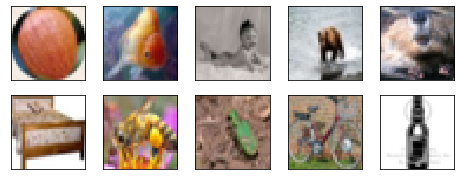

In [6]:
# Show few images from training dataset of CIFAR100

fig = plt.figure(figsize=(8,3))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    #ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# Convert labels into one-hot vectors

img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

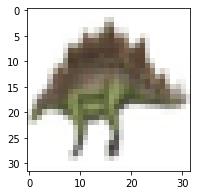

In [8]:
# Show sample image from train dataset

fig = plt.figure(figsize=(3,3))
plt.imshow(x_train[1,:,:,:])

In [9]:
# Display shape of x_train

x_train.shape

(50000, 32, 32, 3)

In [0]:
# Image Augmenters
from albumentations import (Compose, HorizontalFlip, Cutout, PadIfNeeded, RandomCrop)

def CustomImageDataGen(input_img):
    seq = Compose([PadIfNeeded(40,40, p=1),
                   RandomCrop(32,32, p=1),
                   HorizontalFlip(p=0.5),
                   Cutout(num_holes=1, max_h_size=8, max_w_size=8, p=0.5)
                  ], p=1)
    output_img = seq(image = input_img)['image']
    return output_img

In [0]:
# Create image data generators for train and validation/test datasets seperately
# Fit the image data generators to train dataset to obtain mean and standard deviations, so that image standardization can be performed.

from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    preprocessing_function = CustomImageDataGen,
    horizontal_flip=True)
datagen.fit(x_train)

datagen_val = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0)

datagen_val.fit(x_train)

In [12]:
# Print mean and standard deviation of pixel values

print(datagen.mean)
print(datagen.std)

[[[129.30386 124.06987 112.43356]]]
[[[68.1702  65.39176 70.41806]]]


In [13]:
datagen.mean

array([[[129.30386, 124.06987, 112.43356]]], dtype=float32)

In [0]:
# Set the mean and std of both the image data generators to ImageNet mean & std. These values are then used for image standardization.

import numpy as np

datagen.mean = np.array([[[0.485, 0.456, 0.406]]], dtype = np.float32)
datagen.std = np.array([[[0.229, 0.224, 0.225]]], dtype = np.float32)


datagen_val.mean = np.array([[[0.485, 0.456, 0.406]]], dtype = np.float32)
datagen_val.std = np.array([[[0.229, 0.224, 0.225]]], dtype = np.float32)

In [15]:
# Display updated mean and std values

print(datagen.mean)
print(datagen_val.mean)

[[[0.485 0.456 0.406]]]
[[[0.485 0.456 0.406]]]


#### Classification models Zoo - Keras (and TensorFlow Keras) - https://github.com/qubvel/classification_models, forked and modified to https://github.com/ksasi/classification_models

In [16]:
# Install the below repo. This repo is forked as above and ResNet18 is modified to remove Initial maxpool and set the strides of initial 7x7 to stride of 1

!pip install git+https://github.com/ksasi/classification_models.git

  Cloning https://github.com/ksasi/classification_models.git to /tmp/pip-req-build-q79dadno
  Running command git clone -q https://github.com/ksasi/classification_models.git /tmp/pip-req-build-q79dadno
  Running command git submodule update --init --recursive -q
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-cp36-none-any.whl size=19952 sha256=050bb9479f7da749a3a3e3db010434dbba43df568ad1740cdf7438e2a0c782ff
  Stored in directory: /tmp/pip-ephem-wheel-cache-zr1duq24/wheels/a1/d5/94/e536af3b04571f3b182a50e31622b3d9d1c24b7c172b086ae4
Successfully built image-classifiers


In [17]:
# Obtain ResNet18 pre-trained model with ImageNet weights without the classification head

from classification_models.tfkeras import Classifiers
ResNet18, preprocess_input = Classifiers.get('resnet18')
base_model_cifar = ResNet18((32, 32, 3), weights='imagenet', include_top=False)
base_model_cifar.trainable = False

44924928/44920640 [==============================] - 4s 0us/step


In [18]:
# Display model summary

base_model_cifar.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 32, 32, 64)   9408        zero_padding2d[0][0]             
______________________________________________________________________________________________

### Transfer Learning

In [0]:
# Define layers to be used in classification head

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
point_wise_conv2d_layer = tf.keras.layers.Conv2D(filters = 100, kernel_size = 1, use_bias = False)
dense_layer = tf.keras.layers.Dense(100)
softmax_layer = tf.keras.layers.Softmax()

In [0]:
# Define the model where custom classification head is attached to previously obtained pre-trained ResNet18

model = tf.keras.Sequential([
  base_model_cifar,
  point_wise_conv2d_layer,
  global_average_layer,
  dense_layer,
  softmax_layer
])

In [0]:
# Compile the model

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True), loss = 'categorical_crossentropy', metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [22]:
# Display model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 5, 5, 512)         11186889  
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 100)         51200     
_________________________________________________________________
global_average_pooling2d (Gl (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
softmax (Softmax)            (None, 100)               0         
Total params: 11,248,189
Trainable params: 61,300
Non-trainable params: 11,186,889
_________________________________________________________________


In [23]:
len(model.trainable_variables)

3

In [24]:
# Display layers and trainable status. The convolution layers are frozen and classification layers were set as Trainable.

for i in model.layers:
  print(i, i.trainable)

<tensorflow.python.keras.engine.training.Model object at 0x7fa00e09dfd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9ff77a27f0> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f9ff77a2a20> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fa061d0dfd0> True
<tensorflow.python.keras.layers.advanced_activations.Softmax object at 0x7fa061d0da20> True


In [25]:
# Mount google drive to colab

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [26]:
# Define checkpoint and train the model. This is transfer learning.

from math import ceil
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint("/content/drive/My Drive/models/resnet18_cifar100_transfer_learn.h5", monitor='val_categorical_accuracy', verbose=1, save_best_only=True)

batch_size = 512

model.fit_generator(datagen.flow(x_train,y_train,batch_size=batch_size), steps_per_epoch=ceil(len(x_train)/batch_size), epochs = 30, validation_data = datagen_val.flow(x_test,y_test, batch_size=batch_size), validation_steps=ceil(len(x_test)/batch_size), callbacks=[checkpointer])


Epoch 1/30
97/98 [============================>.] - ETA: 0s - loss: 4.2666 - categorical_accuracy: 0.0703
Epoch 00001: val_categorical_accuracy improved from -inf to 0.11610, saving model to /content/drive/My Drive/models/resnet18_cifar100_transfer_learn.h5
98/98 [==============================] - 54s 548ms/step - loss: 4.2628 - categorical_accuracy: 0.0707 - val_loss: 3.8434 - val_categorical_accuracy: 0.1161
Epoch 2/30
97/98 [============================>.] - ETA: 0s - loss: 3.8766 - categorical_accuracy: 0.1141
Epoch 00002: val_categorical_accuracy improved from 0.11610 to 0.15340, saving model to /content/drive/My Drive/models/resnet18_cifar100_transfer_learn.h5
98/98 [==============================] - 47s 476ms/step - loss: 3.8747 - categorical_accuracy: 0.1142 - val_loss: 3.6693 - val_categorical_accuracy: 0.1534
Epoch 3/30
97/98 [============================>.] - ETA: 0s - loss: 3.7573 - categorical_accuracy: 0.1359
Epoch 00003: val_categorical_accuracy improved from 0.15340 to 

### Fine Tuning

In [0]:
# Define learning rate scheduler. Step learning rate is being used.

from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint
def scheduler(epoch):
    if epoch < 30:
        return 0.1
    if 30 <= epoch < 60:
        return 0.02
    if 60 <= epoch < 80:
        return 0.004
    if epoch >= 80 :
        return 0.0008

In [28]:
# Display model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 5, 5, 512)         11186889  
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 100)         51200     
_________________________________________________________________
global_average_pooling2d (Gl (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
softmax (Softmax)            (None, 100)               0         
Total params: 11,248,189
Trainable params: 61,300
Non-trainable params: 11,186,889
_________________________________________________________________


In [0]:
base_model_cifar.trainable = True

In [32]:
len(base_model_cifar.layers)

85

In [33]:
fine_tune_at = len(base_model_cifar.layers) - 17
print(fine_tune_at)

68


In [0]:
# Set last few convolution layers are trainable and remaining layers frozen

for layer in base_model_cifar.layers[:fine_tune_at]:
  layer.trainable = False

In [0]:
# Ensure all BN layers are trainable. Reference https://twitter.com/jeremyphoward/status/1182062808206213120?s=12

for layer in base_model_cifar.layers:
  if "BatchNormalization" in str(layer):
    layer.trainable = True

In [46]:
# Check trainable status for all layers

for i in base_model_cifar.layers:
  print(i, i.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fa061d0d780> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fa061cafbe0> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fa050513f60> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa0798ecf28> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fa0504cde10> True
<tensorflow.python.keras.layers.core.Activation object at 0x7fa050466940> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fa0504666d8> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fa0503dbda0> True
<tensorflow.python.keras.layers.core.Activation object at 0x7fa0503ec5c0> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fa050366ac8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa0503669e8> False
<tensorflo

In [47]:
for i in model.layers:
  print(i, i.trainable)

<tensorflow.python.keras.engine.training.Model object at 0x7fa00e09dfd0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9ff77a27f0> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f9ff77a2a20> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fa061d0dfd0> True
<tensorflow.python.keras.layers.advanced_activations.Softmax object at 0x7fa061d0da20> True


In [0]:
# Compile the model

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True), loss = 'categorical_crossentropy', metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [38]:
# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 5, 5, 512)         11186889  
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 100)         51200     
_________________________________________________________________
global_average_pooling2d (Gl (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
softmax (Softmax)            (None, 100)               0         
Total params: 11,248,189
Trainable params: 7,274,356
Non-trainable params: 3,973,833
_________________________________________________________________


In [48]:
len(model.trainable_variables)

44

In [49]:
# Train the model for 60 epochs with step learning rate

from math import ceil
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint("/content/drive/My Drive/models/resnet18_cifar100_fine_tuned.h5", monitor='val_categorical_accuracy', verbose=1, save_best_only=True)

batch_size = 512


model.fit_generator(datagen.flow(x_train,y_train,batch_size=batch_size), steps_per_epoch=ceil(len(x_train)/batch_size), epochs = 60, validation_data = datagen_val.flow(x_test,y_test, batch_size=batch_size), validation_steps=ceil(len(x_test)/batch_size), callbacks=[LearningRateScheduler(scheduler, verbose=1),checkpointer])



Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/60
97/98 [============================>.] - ETA: 0s - loss: 10.2637 - categorical_accuracy: 0.0263
Epoch 00001: val_categorical_accuracy improved from -inf to 0.01150, saving model to /content/drive/My Drive/models/resnet18_cifar100_fine_tuned.h5
98/98 [==============================] - 49s 503ms/step - loss: 10.2129 - categorical_accuracy: 0.0263 - val_loss: 14.1322 - val_categorical_accuracy: 0.0115

Epoch 00002: LearningRateScheduler reducing learning rate to 0.1.
Epoch 2/60
97/98 [============================>.] - ETA: 0s - loss: 4.8279 - categorical_accuracy: 0.0359
Epoch 00002: val_categorical_accuracy improved from 0.01150 to 0.03200, saving model to /content/drive/My Drive/models/resnet18_cifar100_fine_tuned.h5
98/98 [==============================] - 47s 482ms/step - loss: 4.8302 - categorical_accuracy: 0.0360 - val_loss: 9.7318 - val_categorical_accuracy: 0.0320

Epoch 00003: LearningRateScheduler redu

### Further Fine Tuning

In [50]:
fine_tune_at = len(base_model_cifar.layers) - 20
print(fine_tune_at)

65


In [0]:
# Set more convolutional layers as trainable.

for layer in base_model_cifar.layers[:fine_tune_at]:
  layer.trainable = False

In [52]:
# Display layers and trainable status

for i in base_model_cifar.layers:
  print(i, i.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fa061d0d780> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fa061cafbe0> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fa050513f60> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa0798ecf28> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fa0504cde10> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fa050466940> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fa0504666d8> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fa0503dbda0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fa0503ec5c0> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fa050366ac8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fa0503669e8> False
<tensor

In [0]:
# Ensure all BN layers are trainable. Reference https://twitter.com/jeremyphoward/status/1182062808206213120?s=12

for layer in base_model_cifar.layers:
  if "BatchNormalization" in str(layer):
    layer.trainable = True

In [54]:
for i in model.layers:
  print(i, i.trainable)

<tensorflow.python.keras.engine.training.Model object at 0x7fa00e09dfd0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9ff77a27f0> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f9ff77a2a20> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fa061d0dfd0> True
<tensorflow.python.keras.layers.advanced_activations.Softmax object at 0x7fa061d0da20> True


In [0]:
# Compile the model

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True), loss = 'categorical_crossentropy', metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [56]:
# Display model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 5, 5, 512)         11186889  
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 100)         51200     
_________________________________________________________________
global_average_pooling2d (Gl (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
softmax (Softmax)            (None, 100)               0         
Total params: 11,248,189
Trainable params: 7,278,199
Non-trainable params: 3,969,990
_________________________________________________________________


In [57]:
len(model.trainable_variables)

44

In [58]:
# Train the model i.e. perform further fine tuning

from math import ceil
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint("/content/drive/My Drive/models/resnet18_cifar100_fine_tuned.h5", monitor='val_categorical_accuracy', verbose=1, save_best_only=True)

batch_size = 512


model.fit_generator(datagen.flow(x_train,y_train,batch_size=batch_size), steps_per_epoch=ceil(len(x_train)/batch_size), epochs = 60, validation_data = datagen_val.flow(x_test,y_test, batch_size=batch_size), validation_steps=ceil(len(x_test)/batch_size), callbacks=[LearningRateScheduler(scheduler, verbose=1),checkpointer])



Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/60
97/98 [============================>.] - ETA: 0s - loss: 2.4277 - categorical_accuracy: 0.3913
Epoch 00001: val_categorical_accuracy improved from -inf to 0.19080, saving model to /content/drive/My Drive/models/resnet18_cifar100_fine_tuned.h5
98/98 [==============================] - 51s 523ms/step - loss: 2.4215 - categorical_accuracy: 0.3924 - val_loss: 5.9445 - val_categorical_accuracy: 0.1908

Epoch 00002: LearningRateScheduler reducing learning rate to 0.1.
Epoch 2/60
97/98 [============================>.] - ETA: 0s - loss: 1.6493 - categorical_accuracy: 0.5350
Epoch 00002: val_categorical_accuracy improved from 0.19080 to 0.44420, saving model to /content/drive/My Drive/models/resnet18_cifar100_fine_tuned.h5
98/98 [==============================] - 51s 518ms/step - loss: 1.6493 - categorical_accuracy: 0.5350 - val_loss: 2.2661 - val_categorical_accuracy: 0.4442

Epoch 00003: LearningRateScheduler reducin

## **Observations :**



*   Transfer learning + Fine tuning is carried out for total of 150 epochs
*   Final validation accuracy obtained is 71.60%
*   ResNet18 model is modified so that it can be used with CIFAR100 dataset where image size is 32x32
*   ResNet18 modifications - Removed Initial MaxPool layer. Reduced the stride of 7x7 Convolutional layer from Stride 2 to Stride 1. This helps with retaining the channel size(>2x2) after the last Convolutional layer.




## References & Attributions :



*   https://twitter.com/jeremyphoward/status/1182062808206213120?s=12
*   https://github.com/qubvel/classification_models



###### Disclaimer: The contents of this notebook are used for educational purposes i.e. for learning and research.